In [8]:
# Run this first!!!
from IPython.display import display, HTML

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
import util
sys.path.append('../aho_merging')
from failure_chain_mc import FailureChain
sys.path.append('../common')
import common_probs
from sampling_misc import sample_stat_failure_chain_dist
from sampler import DepthSampler

## Could $\alpha$ be the Problem?

First, a quick check to see if the wrong value of $\alpha$ could have been the reason for the problems seen last time. The plots below show that we can get closer to the average; however, the distribution is still not right, suggesting that there are other problems in the model.

In [27]:
COLORS = ['blue', 'green', 'magenta', 'teal', 'yellow']

def compare_trends(probs, depth, realizations, alphas):
    fcs = [FailureChain(probs, alpha) for alpha in alphas]
    ds = DepthSampler(probs, depth)
    depth_list = range(depth + 1)
    avg_theoreticals = None
    avg_sampled = None
    plt.figure(figsize=(14, 6))
    for _ in xrange(realizations):
        theoreticals = [fc.get_realization_path(depth) for fc in fcs]
        sampled = ds.draw_samples(1, ['failure_chain_path'])['failure_chain_path'].tolist()
        for ind, theoretical in enumerate(theoreticals):
            plt.plot(depth_list, theoretical, COLORS[ind % len(COLORS)], alpha=0.01)
        plt.plot(depth_list, sampled, 'r-', alpha=0.01)
        if avg_theoreticals is None:
            avg_theoreticals = theoreticals
            avg_sampled = sampled
        else:
            for ind, avg_theoretical in enumerate(avg_theoreticals):
                avg_theoreticals[ind] = [avg_theoretical[i] + theoreticals[ind][i]
                                         for i in range(len(theoreticals[ind]))]
            avg_sampled = [avg_sampled[i] + sampled[i] for i in range(len(theoretical))]
    avg_theoreticals = [[val / realizations for val in avg_theoretical]
                        for avg_theoretical in avg_theoreticals]
    avg_sampled = [val / realizations for val in avg_sampled]
    for ind, theoretical in enumerate(avg_theoreticals):
            plt.plot(depth_list, theoretical, COLORS[ind % len(COLORS)], alpha=1)
    plt.plot(depth_list, avg_sampled, 'r-', alpha=1)
    plt.title('Single Path Realizations')
    plt.ylabel('Failure Chain Length')
    plt.xlabel('Depth')
    patches = []
    patches.append(mpatches.Patch(color='red', label='Sampled'))
    for ind, alpha in enumerate(alphas):
        patches.append(mpatches.Patch(color=COLORS[ind % len(COLORS)], label=('Alpha = %f' % alpha)))
    plt.legend(handles=patches)
    plt.show()

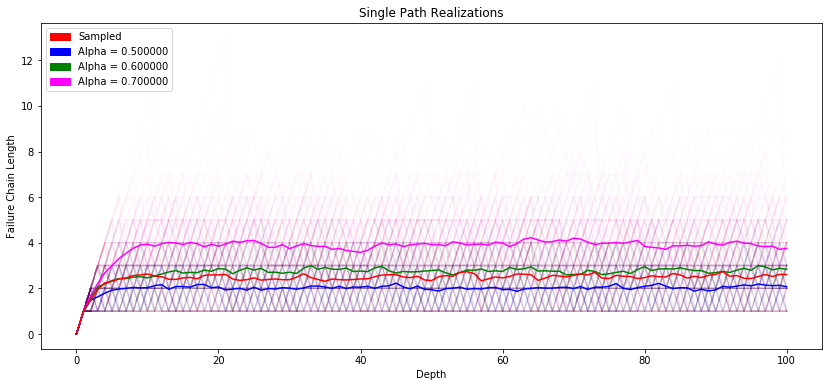

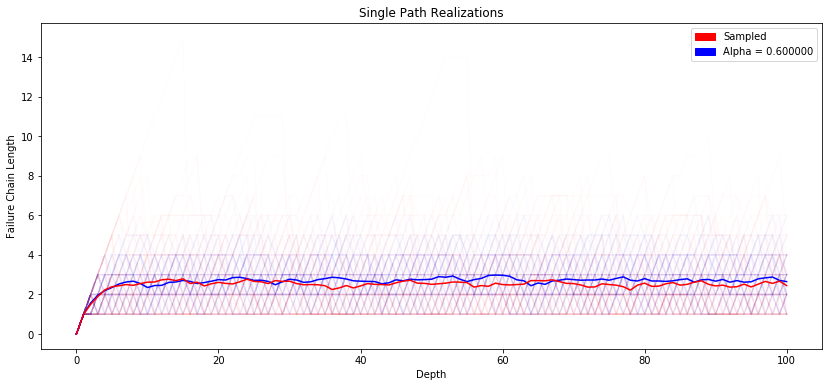

In [28]:
PROBS = [0.25, 0.5, 0.75, 0.3]
DEPTH = 100
REALIZATIONS = 100
ALPHAS = [0.5, 0.6, 0.7]

compare_trends(PROBS, DEPTH, REALIZATIONS, ALPHAS)
compare_trends(PROBS, DEPTH, REALIZATIONS, [0.6])

In [29]:
def compare_stat_dists_against_real(num_samples, probs, depth, alpha):
    fc = FailureChain(probs, alpha)
    theoretical = fc.get_stationary_dist(depth, num_samples)
    print 'Theoretical: \t', theoretical
    sampled = sample_stat_failure_chain_dist(num_samples, probs, depth)
    print 'Sampled: \t', sampled
    s_len, t_len = len(sampled), len(theoretical)
    print 'Relative Difference: '
    print [(sampled[i] - theoretical[i]) / theoretical[i] 
           if i < s_len and i < t_len else float('inf')
           for i in range(max(s_len, t_len))]

In [30]:
NUM_SAMPLES = 1000
PROBS = [0.25, 0.5, 0.75, 0.3]
DEPTH = 50
ALPHA = 0.6

compare_stat_dists_against_real(NUM_SAMPLES, PROBS, DEPTH, ALPHA)

Theoretical: 	[0.132, 0.31, 0.324, 0.181, 0.039, 0.012, 0.001, 0.001]
Sampled: 	[0.248, 0.318, 0.202, 0.116, 0.059, 0.033, 0.015, 0.004, 0.004, 0.0, 0.0, 0.0, 0.001]
Relative Difference: 
[0.8787878787878787, 0.02580645161290325, -0.3765432098765432, -0.3591160220994475, 0.5128205128205128, 1.75, 13.999999999999998, 3.0, inf, inf, inf, inf, inf]


## Making Things More Concrete

All of the above gets into an area where it becomes difficult, if not impossible to prove for the actual structure itself rather than the DFA. While the branching process that I had come up with before does have roots in the model, it becomes hard to make a concrete proof because there are several key assumptions that I made that are hard to account for (depth homogeneity and independence being two key ones). 

Therefore, it might be beneficial to consider taking a similar approach to this but where we are able to prove things in a concrete way. In particular, it could be more beneficial to look at things with regards to the generalized string than the DFA.

As a first attempt, consider $S_n$ which is the number of states at depth $n$ of the DFA. We know that $S_n$ is equivalent to the number of unique failure transitions in depth $n$. Note that we know that depth $n$ has at least one failure transition going to depth $k$ if $G[1:k] == G[n - k:k]$. However, we do not know how many unique failure transitions go to this depth. However, if we assume that $G[1:k] == G[n - k:k] \implies$ that there is a failure transition to all states in depth $k$, the we get an upper bound. In particular,

$$
S_{n + 1} \leq \sum_{k = 0}^n S_k \mathbb{1}_{\left(G[1:k] == G[n - k:k] \right)}
$$

Just to see where we could go with this analysis we need to assume that $S_k$ is independent from $\mathbb{1}_{\left(G[1:k] == G[n - k:k] \right)}$ (which of course it is not). If we this assumption is made however...

$$
E[S_{n + 1}] \leq \sum_{k = 0}^n E[S_k] P\left(G[1:k] == G[n - k:k] \right) = \sum_{k = 0}^n E[S_k] c_2^k
$$

$$
\implies E[S_{n + 1}] \leq E[S_n] + E[S_n] c_2^n = E[S_n](1 + c_2^n)
$$

Thus since $S_1 = 1$ deterministically...

$$
E[S_{n + 1}] \leq \prod_{k = 0}^{n} (1 + c_2^k)
$$

To get an overall upper bound note that...

$$
E[S_{n + 1}] \leq e^{\sum_{k = 0}^n log(1 + c_2^k)}
$$

By log Taylor Series stuff...

$$
E[S_{n + 1}] \leq e^{\sum_{k = 0}^n c_2^k}
$$

As $n \rightarrow \infty$...

$$
\lim_{n \rightarrow \infty} E[S_n] \leq e^{\frac{1}{1 - c_2}}
$$

The plots below try these theories out. It looks like they are indeed upper bounds (that are much better than $2^n$), however they don't seem to be near as good as other model. Plus I assumed something that is totally not true.

In [9]:
def sample(probs, length, num_samples):
    ds = DepthSampler(probs, length)
    return ds.draw_samples(num_samples, ['states', 'threads', 'thread_children', 'new_thread'])

def compute_upper_curve(probs, depth):
    uppers = [1, 1]
    c_2 = common_probs.get_arbitrary_c2(probs)
    curr_prob = 1
    for _ in xrange(depth - 1):
        curr_prob *= c_2
        uppers.append(uppers[-1] * (1 + curr_prob))
    return uppers

def compute_upper_bound(probs):
    c_2 = common_probs.get_arbitrary_c2(probs)
    return np.exp(c_2 / (1 - c_2))

def plot_states(probs, length, num_samples):
    df = sample(probs, length, num_samples)
    states = df.groupby('depth')['states'].mean().tolist()
    depths = range(length + 1)
    plt.plot(depths, states)
    uppers = compute_upper_curve(probs, length)
    plt.plot(depths, uppers)
    upper_bound = compute_upper_bound(probs)
    plt.axhline(upper_bound, ls='--')
    plt.xlabel('Depth')
    plt.ylabel('Average Number of States')
    plt.title('Average Number of States vs Depth')
    plt.show()

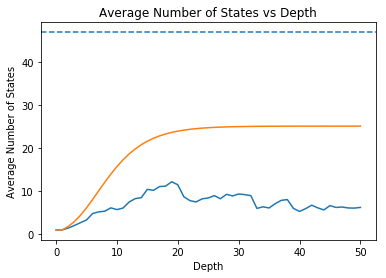

In [10]:
PROBS = [0.25, 0.5, 0.7, 0.3]
DEPTH = 50
NUM_SAMPLES = 40

plot_states(PROBS, DEPTH, NUM_SAMPLES)

## Redoing But With No Assumptions

Now let's take all of these ideas and try to do something that requires no assumptions. First consider the signature of a failure chain that looks something like $(0, 1, 4, 5, \ldots)$. This is the sequence of depths that the failure chain visits. I assert that a failure chain with this signature is unique. Sketch for the proof is something like consider two different chains with same signature (i.e. have different states in the chain). But second state in the chain must be same because both go back to the root. Thus third must be the same, then fourth, etc.

Thus it becomes important to know $\sum_{j < k} \mathbb{1}_{\left(G[1:j] == G[n - j:j] \right)}$ (where $k$ is the depth we are looking if a failure chain goes back to) because these are the other depths that can appear in the failure chain signature. This is a good starting point for future ideas since at least intersection for events here have a more approachable probabilistic interpretation.